In [1]:
# Import Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

import statsmodels.formula.api as smf

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from itertools import product
from scipy.stats import uniform, randint
import time
import joblib
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv('../data/cleaned_sales_data.csv')

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Zip Code,Region,Product ID,Category,Sub-Category,Product Name,Sales Revenue
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Zip Code       9800 non-null   int64  
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales Revenue  9800 non-null   float64
dtypes: float64(1), int64(2), object(14)
memory usage: 1.

## First we'll want to aggregate by weekly sales, set our index to our dates, and check for outliers

In [5]:
# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [6]:
# Aggregate sales by year and month
weekly_sales = df.groupby(pd.Grouper(key='Order Date', freq='W'))['Sales Revenue'].sum().reset_index()

# Rename 'Order Date' to 'Date'
weekly_sales = weekly_sales.rename(columns={'Order Date': 'Date', 'Sales Revenue': 'Sales_Revenue'})

weekly_sales

,Date,Sales_Revenue
0,2015-01-04,304.51
1,2015-01-11,4619.11
2,2015-01-18,4130.53
3,2015-01-25,3092.54
4,2015-02-01,2527.92
...,...,...
204,2018-12-02,35998.92
205,2018-12-09,21537.26
206,2018-12-16,11542.83
207,2018-12-23,19457.04


In [7]:
# Select the most recent 52 values
recent_52_values = weekly_sales.tail(52)

# Sum the 'Sales_Revenue' values
current_annual_sales_revenue = recent_52_values['Sales_Revenue'].sum()

print(f"Most Recent Year's Annual Sales Revenue:, ${current_annual_sales_revenue}")

Most Recent Year's Annual Sales Revenue:, $722051.82


In [8]:
# Set 'Date' as the index and drop the original 'Date' column
weekly_sales.set_index('Date', inplace=True)

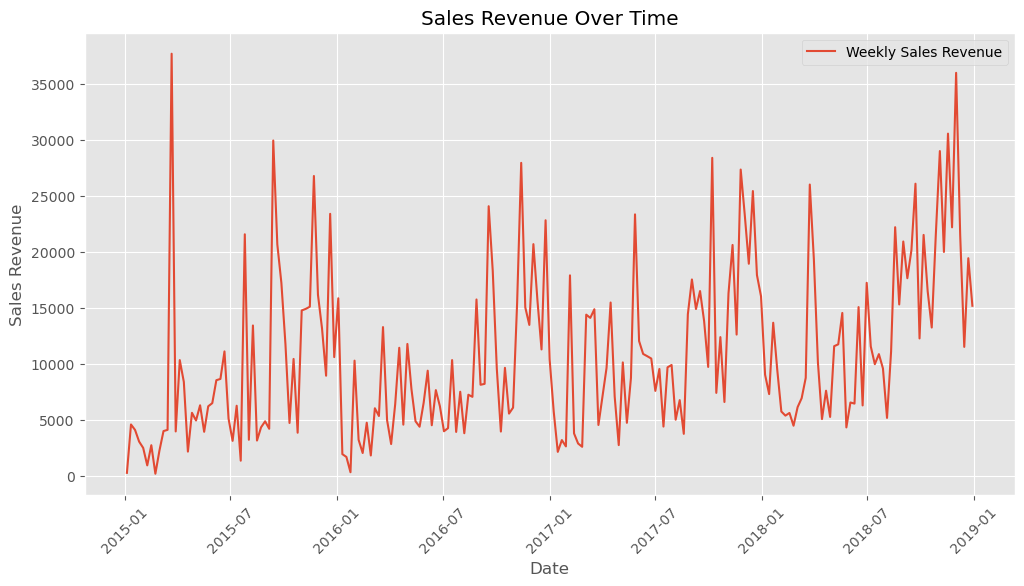

In [9]:
#Plot monthly sales over time
weekly_sales_plot = plt.figure(figsize=(12, 6))
weekly_sales_plot =sns.lineplot(x='Date',
                                      y='Sales_Revenue',
                                      data=weekly_sales,
                                      label='Weekly Sales Revenue')

weekly_sales_plot = plt.xlabel('Date')
weekly_sales_plot = plt.ylabel('Sales Revenue')
weekly_sales_plot = plt.title('Sales Revenue Over Time')
weekly_sales_plot = plt.xticks(rotation=45)

In [10]:
# Find observations where Sales_Revenue > 35000
high_revenue_observations = weekly_sales[weekly_sales['Sales_Revenue'] > 35000]

# Display the result
print(high_revenue_observations)

            Sales_Revenue
Date                     
2015-03-22       37703.68
2018-12-02       35998.92


In [11]:
# Calculate the mean of Sales_Revenue
mean_value = weekly_sales['Sales_Revenue'].mean()

# Impute the observation for 2015-03-22 with the mean value
weekly_sales.loc['2015-03-22', 'Sales_Revenue'] = mean_value

## There was clearly one outlier early on in our date but because we only have just over 200 obervations, dropping the observation isn't as desirable as imputing it with the mean

## Next I've defined functions to add features to our dataset and score the models

In [12]:
def add_lags(df):
    '''
    Create 52-week lag features for 1-3 years
    '''
    target_map = weekly_sales['Sales_Revenue'].to_dict()
    df['Lag_1'] = (df.index -pd.DateOffset(weeks=52)).map(target_map)
    df['Lag_2'] = (df.index -pd.DateOffset(weeks=104)).map(target_map)
    df['Lag_3'] = (df.index -pd.DateOffset(weeks=156)).map(target_map)
    return df

In [13]:
def create_features(df):
    '''
    Creating time series features from the time series index
    '''
    df['Week'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    
    return df

In [14]:
def add_rolling(df):
    '''
    Create rolling mean and rolling standard deviation for 1 and 2 year windows
    '''
    df['Rolling_Mean_1'] = df['Sales_Revenue'].rolling(window=52).mean()
    df['Rolling_Std_1'] = df['Sales_Revenue'].rolling(window=52).std()
    df['Rolling_Mean_2'] = df['Sales_Revenue'].rolling(window=104).mean()
    df['Rolling_Std_2'] = df['Sales_Revenue'].rolling(window=104).std()
    
    return df

In [15]:
add_lags(weekly_sales)

,Sales_Revenue,Lag_1,Lag_2,Lag_3
Date,,,,
2015-01-04,304.51,NaN,NaN,NaN
2015-01-11,4619.11,NaN,NaN,NaN
2015-01-18,4130.53,NaN,NaN,NaN
2015-01-25,3092.54,NaN,NaN,NaN
2015-02-01,2527.92,NaN,NaN,NaN
...,...,...,...,...
2018-12-02,35998.92,23324.75,20712.06,13185.85
2018-12-09,21537.26,18961.00,15675.13,8971.07
2018-12-16,11542.83,25449.81,11314.56,23416.44


In [16]:
add_rolling(weekly_sales)

,Sales_Revenue,Lag_1,Lag_2,Lag_3,Rolling_Mean_1,Rolling_Std_1,Rolling_Mean_2,Rolling_Std_2
Date,,,,,,,,
2015-01-04,304.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-11,4619.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-18,4130.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-25,3092.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-01,2527.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2018-12-02,35998.92,23324.75,20712.06,13185.85,14090.828269,7717.155403,12641.837115,7266.675626
2018-12-09,21537.26,18961.00,15675.13,8971.07,14140.371731,7757.200323,12698.203750,7313.021000
2018-12-16,11542.83,25449.81,11314.56,23416.44,13872.929808,7597.737691,12700.398654,7312.635932


In [17]:
create_features(weekly_sales)

,Sales_Revenue,Lag_1,Lag_2,Lag_3,Rolling_Mean_1,Rolling_Std_1,Rolling_Mean_2,Rolling_Std_2,Week,Month,Year,Quarter
Date,,,,,,,,,,,,
2015-01-04,304.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2015,1
2015-01-11,4619.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2015,1
2015-01-18,4130.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2015,1
2015-01-25,3092.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2015,1
2015-02-01,2527.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-02,35998.92,23324.75,20712.06,13185.85,14090.828269,7717.155403,12641.837115,7266.675626,48,12,2018,4
2018-12-09,21537.26,18961.00,15675.13,8971.07,14140.371731,7757.200323,12698.203750,7313.021000,49,12,2018,4
2018-12-16,11542.83,25449.81,11314.56,23416.44,13872.929808,7597.737691,12700.398654,7312.635932,50,12,2018,4


In [18]:
def symmetric_mean_absolute_percentage_error(y_test, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (sMAPE).
    
    Parameters:
    y_test: Actual values
    y_pred: Predicted values
    
    Returns:
    float: sMAPE value
    """
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100

In [19]:
def mean_absolute_percentage_error(y_test, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): Array of true values.
    y_pred (array-like): Array of predicted values.

    Returns:
    float: MAPE value.
    """
    # Convert inputs to numpy arrays to handle element-wise operations
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return mape

In [20]:
def scoring_metrics(y_test, y_pred):

    """
    Calculate and print various regression evaluation metrics.

    This function calculates four key metrics used to evaluate the performance of 
    regression models: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), 
    and Symmetric Mean Absolute Percentage Error (sMAPE).

    Parameters:
    y_test: Actual values
    y_pred: Predicted values
    """
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Test RMSE: {rmse}")
    print(f"Test MAE: {mae}")
    print(f"sMAPE: {smape}%")
    print(f"MAPE: {mape}%")

# Prophet Model

## The first model we'll be using is a Prophet model. The Prophet model handles seasonal data well so taking the diff of our sales revenue to create stationarity is not necessary. Prophet also works directly with the original scale of the data. There’s no need to scale the data before fitting the model in this case.

In [21]:
# Reset index to get the datetime as a column
df_prophet = weekly_sales.reset_index()

# Rename columns to meet Prophet's requirements
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales_Revenue': 'y'})

In [22]:
df_prophet

,ds,y,Lag_1,Lag_2,Lag_3,Rolling_Mean_1,Rolling_Std_1,Rolling_Mean_2,Rolling_Std_2,Week,Month,Year,Quarter
0,2015-01-04,304.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2015,1
1,2015-01-11,4619.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2015,1
2,2015-01-18,4130.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2015,1
3,2015-01-25,3092.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2015,1
4,2015-02-01,2527.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-12-02,35998.92,23324.75,20712.06,13185.85,14090.828269,7717.155403,12641.837115,7266.675626,48,12,2018,4
205,2018-12-09,21537.26,18961.00,15675.13,8971.07,14140.371731,7757.200323,12698.203750,7313.021000,49,12,2018,4
206,2018-12-16,11542.83,25449.81,11314.56,23416.44,13872.929808,7597.737691,12700.398654,7312.635932,50,12,2018,4
207,2018-12-23,19457.04,17948.26,22843.05,10632.51,13901.944808,7616.463994,12667.840865,7274.477891,51,12,2018,4


In [23]:
# Define the train and test sizes
train_size = len(df_prophet) - 52

# Split the data
train_df_p = df_prophet.iloc[:train_size]
test_df_p = df_prophet.iloc[train_size:]

In [24]:
train_df_p

,ds,y,Lag_1,Lag_2,Lag_3,Rolling_Mean_1,Rolling_Std_1,Rolling_Mean_2,Rolling_Std_2,Week,Month,Year,Quarter
0,2015-01-04,304.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2015,1
1,2015-01-11,4619.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2015,1
2,2015-01-18,4130.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2015,1
3,2015-01-25,3092.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2015,1
4,2015-02-01,2527.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2017-12-03,23324.75,20712.06,13185.85,NaN,11192.845962,6542.824969,9965.477596,6419.588056,48,12,2017,4
153,2017-12-10,18961.00,15675.13,8971.07,NaN,11256.035769,6602.557735,10061.534615,6479.029193,49,12,2017,4
154,2017-12-17,25449.81,11314.56,23416.44,NaN,11527.867500,6889.747418,10081.086250,6522.642529,50,12,2017,4
155,2017-12-24,17948.26,22843.05,10632.51,NaN,11433.736923,6764.420948,10151.430000,6567.938373,51,12,2017,4


In [25]:
# Define ranges for hyperparameters
n_changepoints_list = [10, 20, 25, 30, 35, 40]
changepoint_prior_scales = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
seasonality_prior_scales = [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Grid search loop
for n_changepoints in n_changepoints_list:
    for changepoint_prior_scale in changepoint_prior_scales:
        for seasonality_prior_scale in seasonality_prior_scales:
            try:
                # Define and fit the Prophet model with current parameters
                p_model = Prophet(
                    n_changepoints=n_changepoints,
                    changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale,
                    yearly_seasonality=False,   # Set to False to use custom seasonalities
                    weekly_seasonality=False    # Set to False to use custom seasonalities
                )

                # Add custom seasonality with current fourier_order
                p_model.add_seasonality(name='yearly', period=52, fourier_order=100)
                
                # Fit the model to the training data
                p_model.fit(train_df_p)
                
                # Make predictions
                future = p_model.make_future_dataframe(periods=len(test_df_p), freq='W')
                forecast = p_model.predict(future)
                
                # Extract predictions
                predictions = forecast['yhat'].iloc[-len(test_df_p):].values
                
                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(test_df_p['y'], predictions))
                
                # Check if the current model is better
                if rmse < lowest_rmse:
                    lowest_rmse = rmse
                    best_params = (n_changepoints, changepoint_prior_scale, seasonality_prior_scale)
                    
            except Exception as e:
                print(f"Error with parameters n_changepoints={n_changepoints}, changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}: {e}")

08:25:05 - cmdstanpy - INFO - Chain [1] start processing
08:25:05 - cmdstanpy - INFO - Chain [1] done processing
08:25:05 - cmdstanpy - INFO - Chain [1] start processing
08:25:06 - cmdstanpy - INFO - Chain [1] done processing
08:25:06 - cmdstanpy - INFO - Chain [1] start processing
08:25:06 - cmdstanpy - INFO - Chain [1] done processing
08:25:06 - cmdstanpy - INFO - Chain [1] start processing
08:25:06 - cmdstanpy - INFO - Chain [1] done processing
08:25:06 - cmdstanpy - INFO - Chain [1] start processing
08:25:06 - cmdstanpy - INFO - Chain [1] done processing
08:25:06 - cmdstanpy - INFO - Chain [1] start processing
08:25:06 - cmdstanpy - INFO - Chain [1] done processing
08:25:07 - cmdstanpy - INFO - Chain [1] start processing
08:25:07 - cmdstanpy - INFO - Chain [1] done processing
08:25:07 - cmdstanpy - INFO - Chain [1] start processing
08:25:07 - cmdstanpy - INFO - Chain [1] done processing
08:25:07 - cmdstanpy - INFO - Chain [1] start processing
08:25:07 - cmdstanpy - INFO - Chain [1]

In [26]:
print(f"Best n_changepoints: {best_params[0]}")
print(f"Best changepoint_prior_scale: {best_params[1]}")
print(f"Best seasonality_prior_scale: {best_params[2]}")
print(f"Lowest RMSE: {lowest_rmse}")

Best n_changepoints: 30
Best changepoint_prior_scale: 0.005
Best seasonality_prior_scale: 57
Lowest RMSE: 6194.932136253038


In [27]:
# Adjusted parameters
p_model = Prophet(
    n_changepoints=30,                 # Increase to capture more potential changepoints
    changepoint_prior_scale=.005,      # Lower to allow for more abrupt changes in trends
    seasonality_prior_scale=57,        # Increase to allow more flexibility in seasonal patterns
    yearly_seasonality=False,          # Set to False if adding custom seasonalities like below
    weekly_seasonality=False,
    interval_width=0.95
)

# Optionally add custom seasonalities or external regressors
p_model.add_seasonality(name='yearly', period=52, fourier_order=100)
# Fit the model to the training data
p_model.fit(train_df_p)

08:27:23 - cmdstanpy - INFO - Chain [1] start processing
08:27:24 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
df_prophet_forecast = p_model.predict(test_df_p)
df_prophet_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-07,9234.147645,-933.306238,17173.354782,9234.147641,9234.147647,-1263.891593,-1263.891593,-1263.891593,-1263.891593,-1263.891593,-1263.891593,0.0,0.0,0.0,7970.256052
1,2018-01-14,9268.514344,-2389.894154,15497.204972,9268.514331,9268.514352,-2577.349519,-2577.349519,-2577.349519,-2577.349519,-2577.349519,-2577.349519,0.0,0.0,0.0,6691.164825
2,2018-01-21,9302.881043,-2006.614897,14927.885062,9302.881018,9302.881060,-3080.597229,-3080.597229,-3080.597229,-3080.597229,-3080.597229,-3080.597229,0.0,0.0,0.0,6222.283813
3,2018-01-28,9337.247741,135.522813,17885.499642,9337.247704,9337.247770,-129.286650,-129.286650,-129.286650,-129.286650,-129.286650,-129.286650,0.0,0.0,0.0,9207.961092
4,2018-02-04,9371.614440,2627.769205,19841.776033,9371.614391,9371.614481,2182.561366,2182.561366,2182.561366,2182.561366,2182.561366,2182.561366,0.0,0.0,0.0,11554.175806
5,2018-02-11,9405.981139,-2203.052386,15120.131600,9405.981076,9405.981193,-2849.811666,-2849.811666,-2849.811666,-2849.811666,-2849.811666,-2849.811666,0.0,0.0,0.0,6556.169473
6,2018-02-18,9440.347838,-1683.959197,14735.006251,9440.347761,9440.347906,-3296.255507,-3296.255507,-3296.255507,-3296.255507,-3296.255507,-3296.255507,0.0,0.0,0.0,6144.092331
7,2018-02-25,9474.714537,-2291.984073,14602.894250,9474.714442,9474.714622,-3378.503680,-3378.503680,-3378.503680,-3378.503680,-3378.503680,-3378.503680,0.0,0.0,0.0,6096.210857
8,2018-03-04,9509.081236,3906.671641,21328.282727,9509.081118,9509.081337,2607.357107,2607.357107,2607.357107,2607.357107,2607.357107,2607.357107,0.0,0.0,0.0,12116.438343
9,2018-03-11,9543.447935,2443.436293,20843.954898,9543.447801,9543.448050,2362.373844,2362.373844,2362.373844,2362.373844,2362.373844,2362.373844,0.0,0.0,0.0,11905.821779


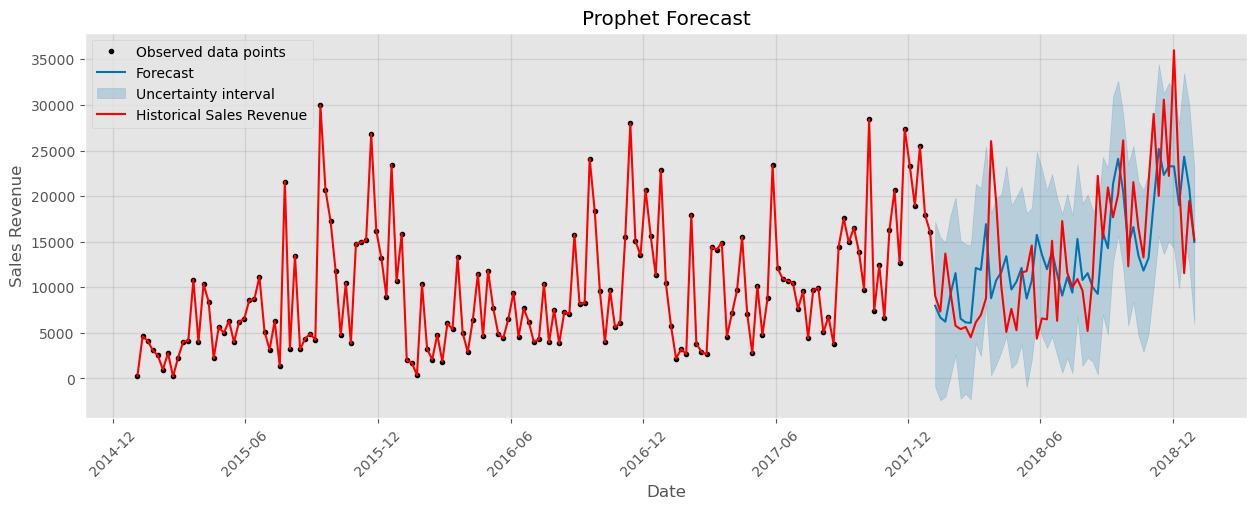

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
fig = p_model.plot(df_prophet_forecast, ax=ax)
# Plot the historical data as a line
ax.plot(df_prophet['ds'], df_prophet['y'], label='Historical Sales Revenue', color='red')
# Show the legend
ax.legend()
ax.set_title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.xticks(rotation=45)
plt.show()

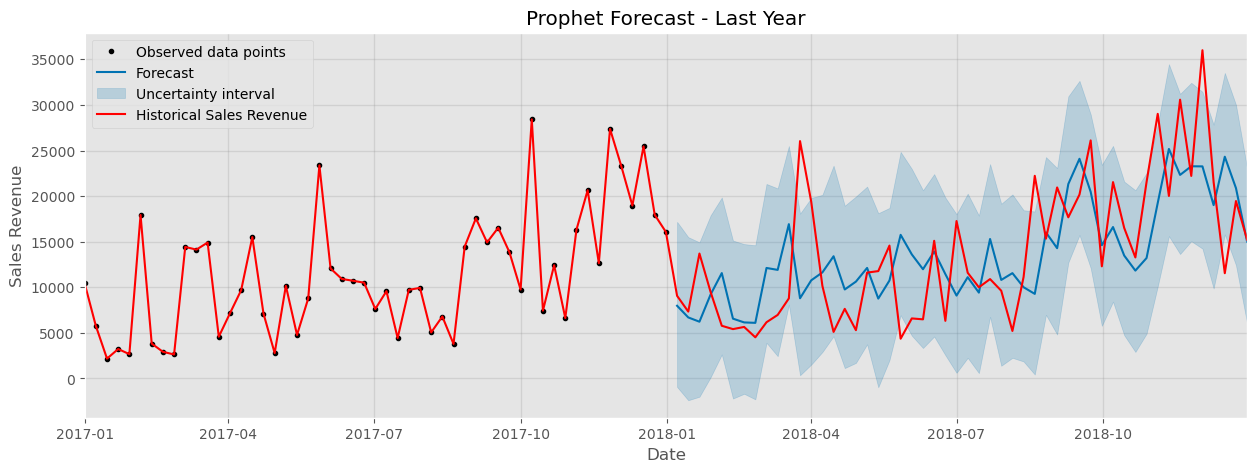

In [30]:
# Filter the data to include only the last year
last_year = df_prophet[df_prophet['ds'] >= df_prophet['ds'].max() - pd.DateOffset(years=2)]

# Plot the Prophet forecast
fig, ax = plt.subplots(figsize=(15, 5))
fig = p_model.plot(df_prophet_forecast, ax=ax)

# Plot the historical data for the last year as a line
ax.plot(last_year['ds'], last_year['y'], label='Historical Sales Revenue', color='red')

# Set the x-axis limit to show only the last year
ax.set_xlim([last_year['ds'].min(), df_prophet['ds'].max()])

# Show the legend and labels
ax.legend()
ax.set_title('Prophet Forecast - Last Year')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.show()

In [31]:
# Score the model
scoring_metrics(test_df_p['y'], df_prophet_forecast['yhat'])

Test RMSE: 6194.932136253038
Test MAE: 4768.296177626506
sMAPE: 36.0411070068826%
MAPE: 43.91971362957048%


In [32]:
# Adjusted parameters
p_model = Prophet(
    n_changepoints=30,                 # Increase to capture more potential changepoints
    changepoint_prior_scale=.005,      # Lower to allow for more abrupt changes in trends
    seasonality_prior_scale=57,        # Increase to allow more flexibility in seasonal patterns
    yearly_seasonality=False,          # Keep if yearly seasonality is relevant
    weekly_seasonality=False,
    interval_width=0.95
)
# Optionally add custom seasonalities or external regressors
p_model.add_seasonality(name='yearly', period=52, fourier_order=100)

# Fit the model to the training data
p_model.fit(df_prophet)

08:27:24 - cmdstanpy - INFO - Chain [1] start processing
08:27:24 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future = p_model.make_future_dataframe(periods=52, freq='W', include_history=False)
future_forecast = p_model.predict(future)

In [34]:
future_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-06,13750.844757,2258.572425,21353.876212,13750.844738,13750.844772,-1616.339302,-1616.339302,-1616.339302,-1616.339302,-1616.339302,-1616.339302,0.0,0.0,0.0,12134.505456
1,2019-01-13,13803.866935,1092.585391,19957.611752,13803.866876,13803.866987,-3159.150908,-3159.150908,-3159.150908,-3159.150908,-3159.150908,-3159.150908,0.0,0.0,0.0,10644.716028
2,2019-01-20,13856.889113,2814.310927,21122.975125,13856.889006,13856.889211,-1999.398327,-1999.398327,-1999.398327,-1999.398327,-1999.398327,-1999.398327,0.0,0.0,0.0,11857.490786
3,2019-01-27,13909.911291,3592.584783,21685.449967,13909.911125,13909.911459,-903.750992,-903.750992,-903.750992,-903.750992,-903.750992,-903.750992,0.0,0.0,0.0,13006.160300
4,2019-02-03,13962.933469,4735.856742,22869.527310,13962.933226,13962.933705,-150.378063,-150.378063,-150.378063,-150.378063,-150.378063,-150.378063,0.0,0.0,0.0,13812.555406
5,2019-02-10,14015.955647,1835.441570,19912.563591,14015.955323,14015.955941,-3778.067579,-3778.067579,-3778.067579,-3778.067579,-3778.067579,-3778.067579,0.0,0.0,0.0,10237.888069
6,2019-02-17,14068.977825,1021.197748,18735.530846,14068.977423,14068.978192,-3971.637036,-3971.637036,-3971.637036,-3971.637036,-3971.637036,-3971.637036,0.0,0.0,0.0,10097.340790
7,2019-02-24,14122.000004,639.168782,18665.122740,14121.999522,14122.000444,-4563.493443,-4563.493443,-4563.493443,-4563.493443,-4563.493443,-4563.493443,0.0,0.0,0.0,9558.506561
8,2019-03-03,14175.022182,4772.664773,23853.713829,14175.021627,14175.022730,295.650178,295.650178,295.650178,295.650178,295.650178,295.650178,0.0,0.0,0.0,14470.672359
9,2019-03-10,14228.044360,5072.482203,24291.802399,14228.043720,14228.045008,224.208002,224.208002,224.208002,224.208002,224.208002,224.208002,0.0,0.0,0.0,14452.252361


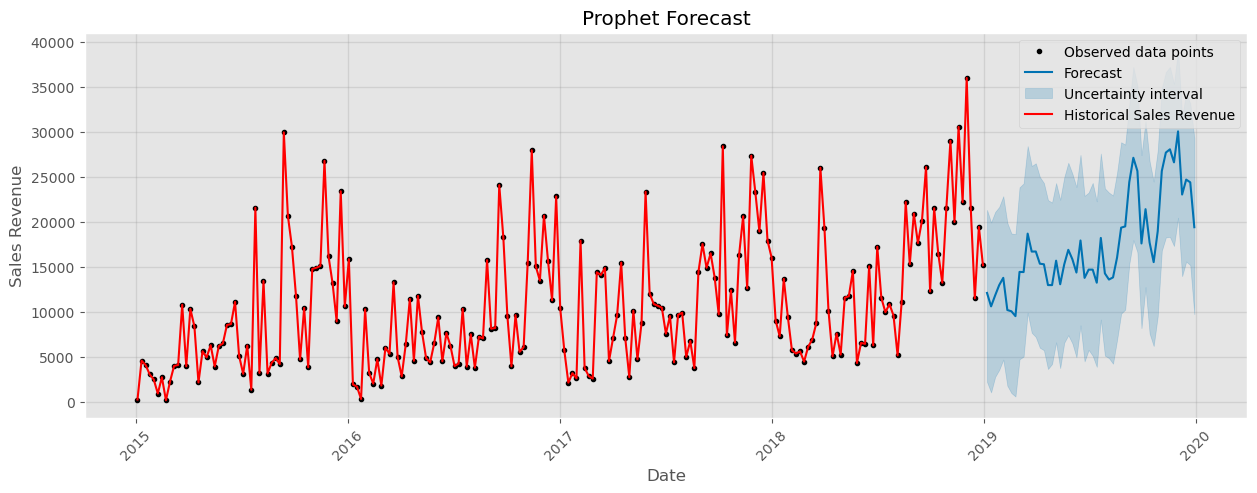

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
fig = p_model.plot(future_forecast, ax=ax)
# Plot the historical data as a line
ax.plot(df_prophet['ds'], df_prophet['y'], label='Historical Sales Revenue', color='red')
# Show the legend
ax.legend()
ax.set_title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.xticks(rotation=45)
plt.show()

In [36]:
total_sum_yhat = future_forecast['yhat'].sum()

print(f"Next year's forecasted Total Sales Revenue: ${round(total_sum_yhat, 2)}")
print(f"Most Recent Year's Annual Sales Revenue: ${current_annual_sales_revenue}")

percentage_increase = ((total_sum_yhat - current_annual_sales_revenue) / current_annual_sales_revenue) * 100
print(f"Projected Annual Increase in Sales Revenue for Next Year: {round(percentage_increase, 2)}%")

Next year's forecasted Total Sales Revenue: $908327.94
Most Recent Year's Annual Sales Revenue: $722051.82
Projected Annual Increase in Sales Revenue for Next Year: 25.8%


In [37]:
# Export our model

# Define the file path
folder_path = '../models'
model_path = os.path.join(folder_path, 'prophet_model.pkl')

# Export the model
joblib.dump(p_model, model_path)

['../models/prophet_model.pkl']

# Holt-Winters Model

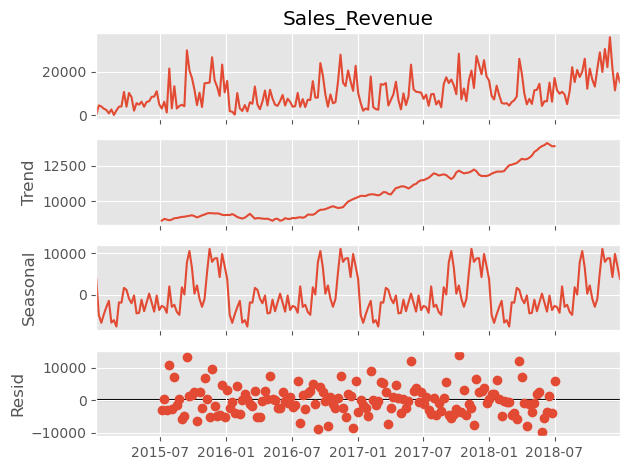

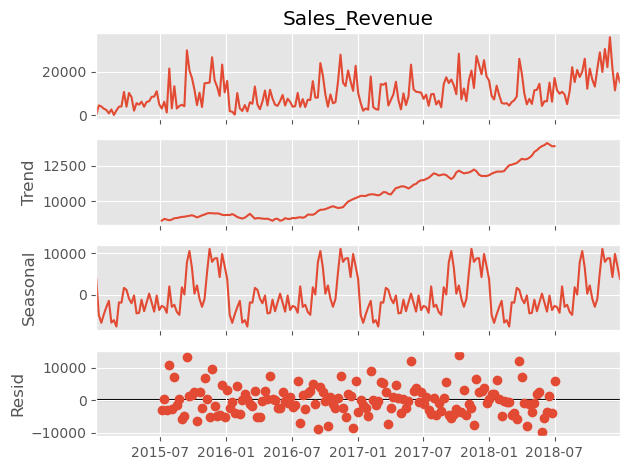

In [38]:
decomposition = seasonal_decompose(weekly_sales['Sales_Revenue'], model='additive')
decomposition.plot()

In [39]:
# Confirm the frequency is set to weekly
weekly_sales = weekly_sales.asfreq('W')

In [40]:
# Define the train and test sizes
train_size = len(weekly_sales) - 52

# Split the data
train_df = weekly_sales.iloc[:train_size]
test_df = weekly_sales.iloc[train_size:]

In [41]:
# Define ranges for hyperparameters
smoothing_levels = [0.05, 0.06, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
smoothing_trends = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.105, 0.106, 0.107, 0.108, 0.109, 0.11, 0.12, 0.13, 0.14, 0.15]
smoothing_seasonals = [0.1, 0.15, 0.2, 0.25, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.45, 0.5]

# Placeholder for the best parameters and lowest RMSE
best_params = None
lowest_rmse = float('inf')

# Grid search loop
for level in smoothing_levels:
    for trend in smoothing_trends:
        for seasonal in smoothing_seasonals:
            try:
                # Define and fit the Holt-Winters model with current parameters
                model = ExponentialSmoothing(
                    train_df['Sales_Revenue'],
                    trend='add', 
                    seasonal='add', 
                    seasonal_periods=52,
                    #use_boxcox=True  # Apply Box-Cox transformation
                )
                
                hw_model = model.fit(
                    smoothing_level=level,
                    smoothing_trend=trend,
                    smoothing_seasonal=seasonal,
                    optimized=False
                )
                
                # Make predictions
                predictions = hw_model.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
                
                # Debugging: Check for NaN values
                if np.any(np.isnan(predictions)):
                    print(f"NaNs found in predictions with level={level}, trend={trend}, seasonal={seasonal}")
                    continue
                
                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(test_df['Sales_Revenue'], predictions))
                
                # Check if the current model is better
                if rmse < lowest_rmse:
                    lowest_rmse = rmse
                    best_params = (level, trend, seasonal)
                    
            except Exception as e:
                print(f"Error with parameters level={level}, trend={trend}, seasonal={seasonal}: {e}")

# Print the best parameters and the lowest RMSE
print(f"Best smoothing_level: {best_params[0]}")
print(f"Best smoothing_trend: {best_params[1]}")
print(f"Best smoothing_seasonal: {best_params[2]}")
print(f"Lowest RMSE: {lowest_rmse}")

Best smoothing_level: 0.068
Best smoothing_trend: 0.106
Best smoothing_seasonal: 0.33
Lowest RMSE: 6406.790556674098


In [42]:
# Define and fit the Holt-Winters model
model = ExponentialSmoothing(
    train_df['Sales_Revenue'],
    trend='add', 
    seasonal='add', 
    seasonal_periods=52,
    #use_boxcox=True  # Apply Box-Cox transformation
)
# Fit the model with specific smoothing parameters
hw_model = model.fit(smoothing_level=best_params[0],   # Adjust based on how quickly the model should adapt to changes
    smoothing_trend=best_params[1],   # A higher value to capture the linear trend after the flat period
    smoothing_seasonal=best_params[2], # A higher value to ensure the seasonality is well captured
    optimized=False        # Disable automatic optimization to use specified parameters
)

In [43]:
# Print model summary
print(hw_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:            Sales_Revenue   No. Observations:                  157
Model:             ExponentialSmoothing   SSE                     4152439369.699
Optimized:                        False   AIC                           2795.242
Trend:                         Additive   BIC                           2966.392
Seasonal:                      Additive   AICC                          2865.079
Seasonal Periods:                    52   Date:                 Tue, 13 Aug 2024
Box-Cox:                          False   Time:                         08:27:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0680000                alpha                False
smoothing_trend          

In [44]:
# Forecast the length of the test set
forecast = hw_model.predict(start=test_df.index[0], end=test_df.index[-1])

# Create a DataFrame for predictions
forecast_df = pd.DataFrame({'Forecast': forecast})
forecast_df.index = test_df.index

In [45]:
# Merge the forecast with the actual values
results = pd.DataFrame({
    'Actual': test_df['Sales_Revenue'],
    'Forecast': forecast
})

# Compute performance metrics
scoring_metrics(results['Actual'], results['Forecast'])

Test RMSE: 6406.790556674098
Test MAE: 4955.925038012658
sMAPE: 37.77575431914081%
MAPE: 45.7053221152064%


In [46]:
# Define the end of the historical period
end_date = weekly_sales.index.max()

# Define the start date for the last 2 years
start_date = end_date - pd.DateOffset(weeks=104)

# Extract the last 2 years of historical data
last_2_years = weekly_sales[start_date:]

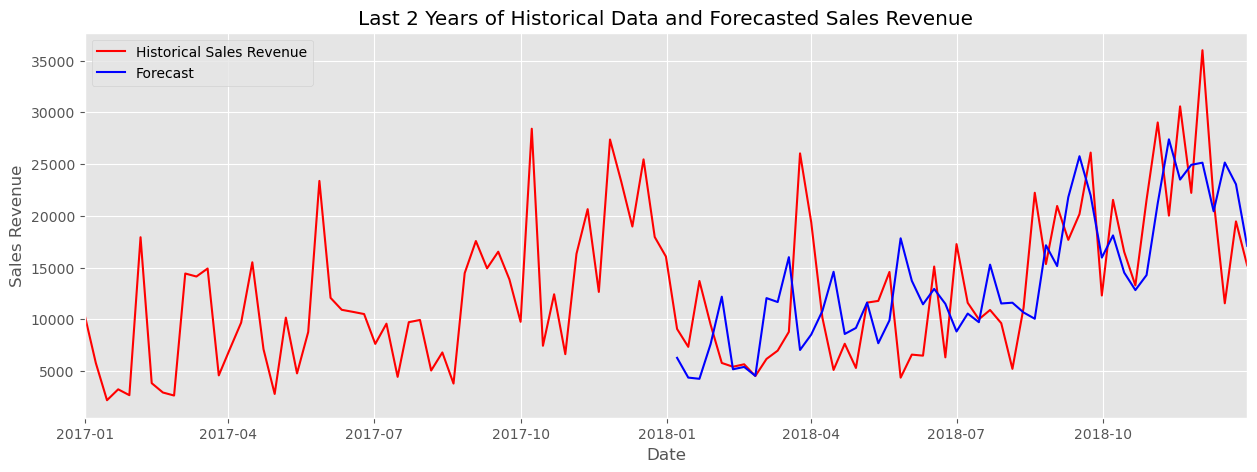

In [47]:
# Plot the last 2 years of historical data and forecast
plt.figure(figsize=(15, 5))

# Plot the last 2 years of historical data
plt.plot(last_2_years.index, last_2_years['Sales_Revenue'], label='Historical Sales Revenue', color='red')

# Plot the forecast data
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')

# Set the x-axis limits to cover the last 2 years and forecast period
plt.xlim([last_2_years.index.min(), forecast_df.index.max()])

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.title('Last 2 Years of Historical Data and Forecasted Sales Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Set the frequency to weekly
weekly_sales = weekly_sales.asfreq('W')

# Define and fit the Holt-Winters model
model = ExponentialSmoothing(
    weekly_sales['Sales_Revenue'],
    trend='add', 
    seasonal='add', 
    seasonal_periods=52,
    #use_boxcox=True  # Apply Box-Cox transformation
)

# Fit the model with specific smoothing parameters
hw_model = model.fit(smoothing_level=best_params[0],   # Adjust based on how quickly the model should adapt to changes
    smoothing_trend=best_params[1],   # A higher value to capture the linear trend after the flat period
    smoothing_seasonal=best_params[2], # A higher value to ensure the seasonality is well captured
    optimized=False        # Disable automatic optimization to use specified parameters
)

# Print model summary
print(hw_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:            Sales_Revenue   No. Observations:                  209
Model:             ExponentialSmoothing   SSE                     6111974651.899
Optimized:                        False   AIC                           3704.957
Trend:                         Additive   BIC                           3892.128
Seasonal:                      Additive   AICC                          3750.584
Seasonal Periods:                    52   Date:                 Tue, 13 Aug 2024
Box-Cox:                          False   Time:                         08:27:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0680000                alpha                False
smoothing_trend          

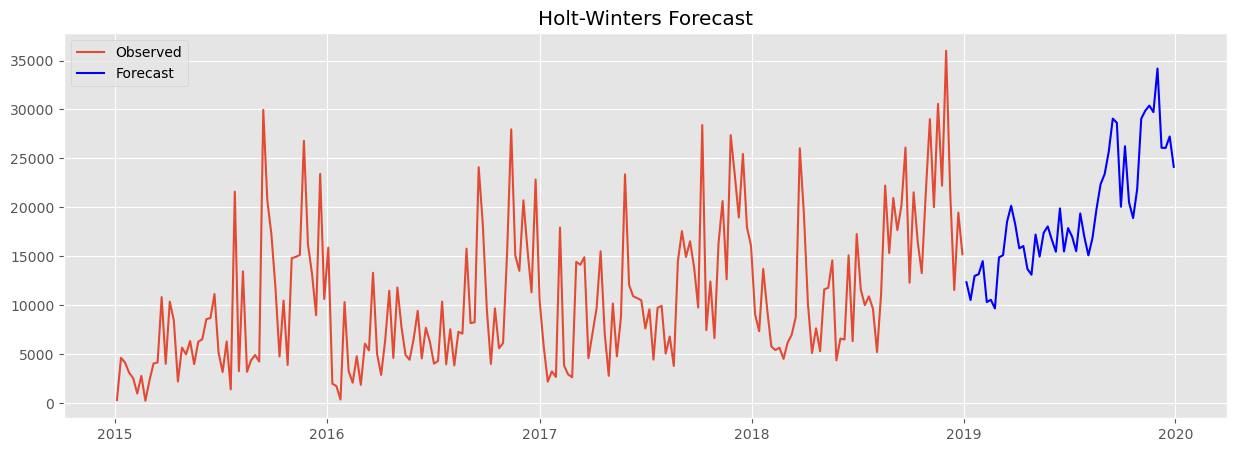

In [49]:
# Forecasting future values
forecast_steps = 52  # Forecast the next year (52 weeks)
forecast = hw_model.forecast(steps=forecast_steps)

# Generate future dates
future_dates = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')
forecast_series = pd.Series(forecast, index=future_dates)

# Plot the forecast
plt.figure(figsize=(15, 5))
plt.plot(weekly_sales['Sales_Revenue'], label='Observed')
plt.plot(forecast_series, label='Forecast', color='blue')
plt.title('Holt-Winters Forecast')
plt.legend()
plt.show()

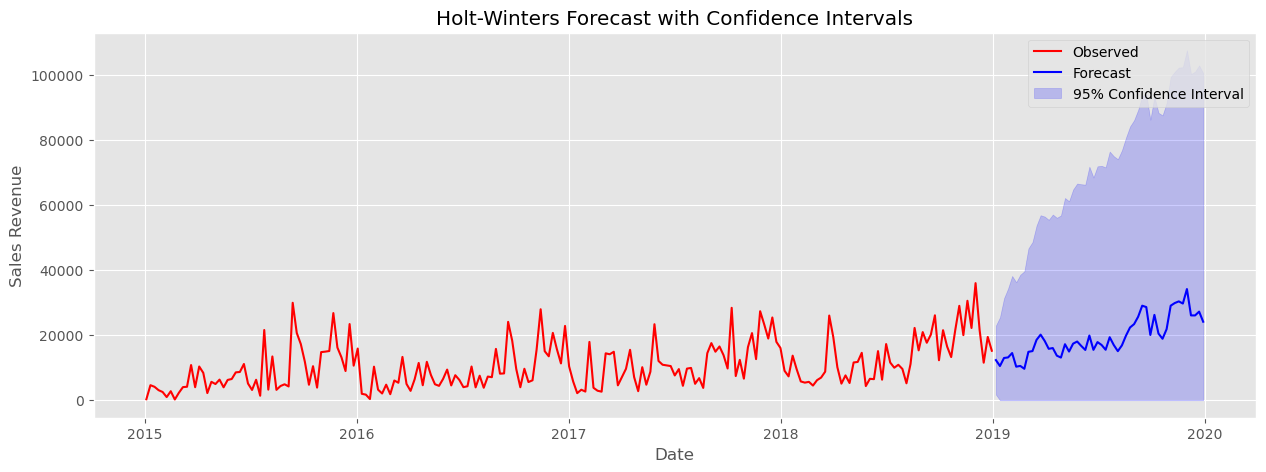

In [50]:
# Define a confidence level (e.g., 95%)
alpha = 0.05
z = 1.96  # For a 95% confidence interval

# Calculate the standard deviation of the residuals
residuals = hw_model.resid
residual_std = np.std(residuals)

# Calculate the confidence intervals
forecast_std_error = residual_std * np.sqrt(np.arange(1, forecast_steps + 1))

# Upper and lower bounds of the confidence intervals
ci_upper = forecast_series + z * forecast_std_error
ci_lower = np.maximum(forecast_series - z * forecast_std_error, 0)  # Ensure ci_lower is not below 0

# Plot the forecast with confidence intervals
plt.figure(figsize=(15, 5))

# Plot the observed data
plt.plot(weekly_sales['Sales_Revenue'], label='Observed', color='red')

# Plot the forecasted values
plt.plot(forecast_series, label='Forecast', color='blue')

# Plot the confidence intervals
plt.fill_between(future_dates, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.title('Holt-Winters Forecast with Confidence Intervals')
plt.show()

In [51]:
total_sum_forecast = forecast_series.sum()

print(f"Next year's forecasted Total Sales Revenue: ${round(total_sum_forecast, 2)}")
print(f"Most Recent Year's Annual Sales Revenue: ${current_annual_sales_revenue}")

percentage_increase = ((total_sum_forecast - current_annual_sales_revenue) / current_annual_sales_revenue) * 100
print(f"Projected Annual Increase in Sales Revenue for Next Year: {round(percentage_increase, 2)}%")

Next year's forecasted Total Sales Revenue: $1006757.06
Most Recent Year's Annual Sales Revenue: $722051.82
Projected Annual Increase in Sales Revenue for Next Year: 39.43%


In [52]:
# Export our model

# Define the file path
folder_path = '../models'
model_path = os.path.join(folder_path, 'holt_winters_model.pkl')

# Export the model
joblib.dump(hw_model, model_path)

['../models/holt_winters_model.pkl']

# SARIMA Model

## Although the first two models did not require stationarity, a SARIMA Model does require stationarity. We will begin by running an Augmented Dickey-Fuller (ADF) Test to determine if our data is stationary.

In [53]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(weekly_sales['Sales_Revenue'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, series is non-stationary, apply differencing
if result[1] > 0.05:
    weekly_sales['Sales_Revenue_diff'] = weekly_sales['Sales_Revenue'].diff().dropna()
else:
    weekly_sales['Sales_Revenue_diff'] = weekly_sales['Sales_Revenue']

ADF Statistic: -5.573942183361179
p-value: 1.4463694703510823e-06


## An ADF statistic of -5.57 is quite negative which suggests the time series is likely stationary. With such a small p-value, we can confidently reject the null hypothesis that the time series data is non-stationary.

In [54]:
weekly_sales['Sales_Revenue_seasonal_diff'] = weekly_sales['Sales_Revenue'] - weekly_sales['Sales_Revenue'].shift(52)

In [55]:
result = adfuller(weekly_sales['Sales_Revenue_seasonal_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -13.904644116544597
p-value: 5.652031163080757e-26


In [56]:
weekly_sales

,Sales_Revenue,Lag_1,Lag_2,Lag_3,Rolling_Mean_1,Rolling_Std_1,Rolling_Mean_2,Rolling_Std_2,Week,Month,Year,Quarter,Sales_Revenue_diff,Sales_Revenue_seasonal_diff
Date,,,,,,,,,,,,,,
2015-01-04,304.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2015,1,304.51,NaN
2015-01-11,4619.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2015,1,4619.11,NaN
2015-01-18,4130.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2015,1,4130.53,NaN
2015-01-25,3092.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2015,1,3092.54,NaN
2015-02-01,2527.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2,2015,1,2527.92,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-02,35998.92,23324.75,20712.06,13185.85,14090.828269,7717.155403,12641.837115,7266.675626,48,12,2018,4,35998.92,12674.17
2018-12-09,21537.26,18961.00,15675.13,8971.07,14140.371731,7757.200323,12698.203750,7313.021000,49,12,2018,4,21537.26,2576.26
2018-12-16,11542.83,25449.81,11314.56,23416.44,13872.929808,7597.737691,12700.398654,7312.635932,50,12,2018,4,11542.83,-13906.98


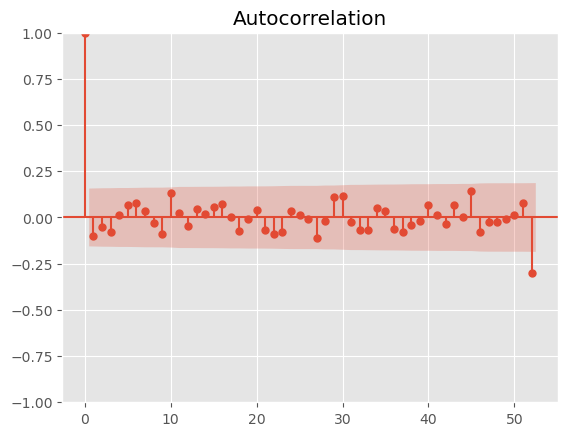

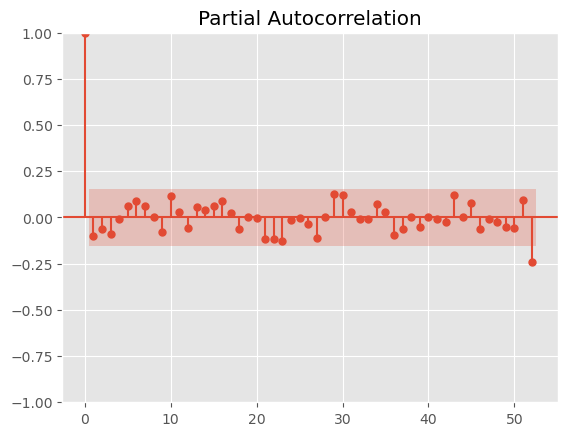

In [57]:
# Plot ACF and PACF for the seasonally differenced series
plot_acf(weekly_sales['Sales_Revenue_seasonal_diff'].dropna(), lags=52)
plot_pacf(weekly_sales['Sales_Revenue_seasonal_diff'].dropna(), lags=52)
plt.show()

In [58]:
# Define the train and test sizes
train_size = len(weekly_sales) - 52

# Split the data
train_df = weekly_sales.iloc[:train_size]
test_df = weekly_sales.iloc[train_size:]

In [59]:
model = SARIMAX(train_df['Sales_Revenue'], 
                order=(1, 0, 1),                   #order=(p, d, q), e.g., (1, 0, 1)
                seasonal_order=(1, 1, 1, 52),      #seasonal_order=(P, D, Q, m))  e.g., (1, 1, 1, 52)
                trend='t',
                #optimizer='bfgs',
                time_varying_regression=True,
                initialization='approximate_diffuse',
                concentrate_scale=True,
                mle_regression=False
               )

sarima_model = model.fit(disp=False, maxiter=250)

print(sarima_model.summary())

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                      Sales_Revenue   No. Observations:                  157
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1941.604
Date:                            Tue, 13 Aug 2024   AIC                           3895.209
Time:                                    08:32:14   BIC                           3913.546
Sample:                                01-04-2015   HQIC                          3902.656
                                     - 12-31-2017   Scale                     10089733.997
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         29.8077      5.352      5.569      0.000      19.318      40.298
ar.L1         -1.0000      0.013   

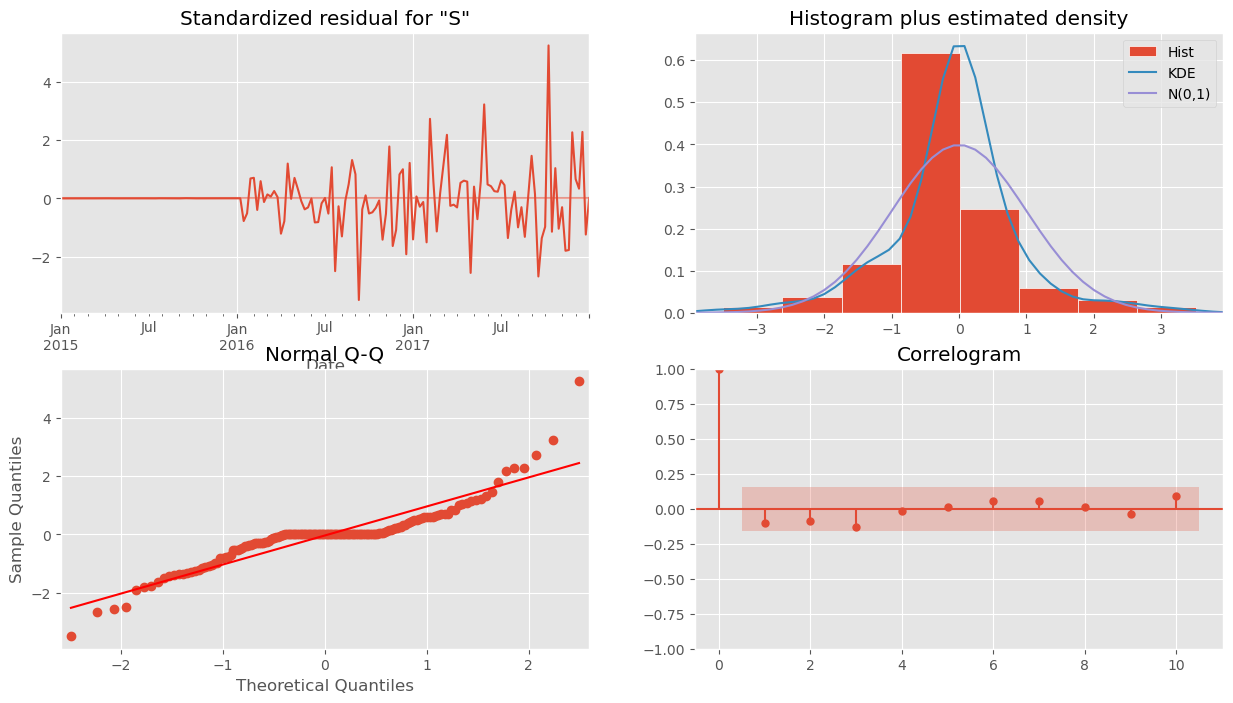

AIC: 3895.2086932287075


In [60]:
# Plot residuals
sarima_model.plot_diagnostics(figsize=(15, 8))
plt.show()

# Calculate AIC for model comparison
print(f'AIC: {sarima_model.aic}')

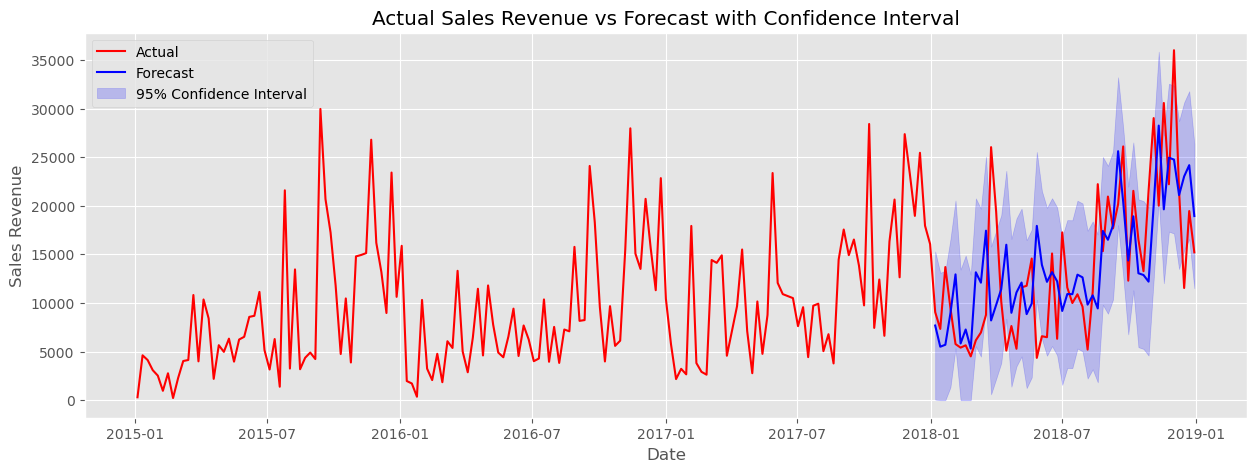

In [61]:
# Generate Forecasts
forecast = sarima_model.get_forecast(steps=len(test_df))

# Create DataFrame for Forecasted Values
forecast_df = forecast.summary_frame().rename(columns={'mean': 'Forecast'})
forecast_index = test_df.index
forecast_df.index = forecast_index

# Plot Actual vs Forecast
plt.figure(figsize=(15, 5))
plt.plot(weekly_sales['Sales_Revenue'], label='Actual', color='red')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')

# Ensure lower confidence interval does not drop below 0
forecast_df['mean_ci_lower'] = forecast_df['mean_ci_lower'].clip(lower=0)

# Plot confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('Actual Sales Revenue vs Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.show()

In [62]:
# Score the model
scoring_metrics(test_df['Sales_Revenue'], forecast_df['Forecast'])

Test RMSE: 6520.696678861441
Test MAE: 5049.273163083631
sMAPE: 37.73105478395037%
MAPE: 47.34892951388668%


In [63]:
model = SARIMAX(weekly_sales['Sales_Revenue'], 
                order=(1, 0, 1),                   #order=(p, d, q), e.g., (1, 0, 1)
                seasonal_order=(1, 1, 1, 52),      #seasonal_order=(P, D, Q, m))  e.g., (1, 1, 1, 52)
                trend='t',
                #optimizer='bfgs',
                time_varying_regression=True,
                initialization='approximate_diffuse',
                concentrate_scale=True,
                mle_regression=False
               )

sarima_model = model.fit(disp=False, maxiter=250)

print(sarima_model.summary())

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                      Sales_Revenue   No. Observations:                  209
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -2472.499
Date:                            Tue, 13 Aug 2024   AIC                           4956.997
Time:                                    08:37:53   BIC                           4977.051
Sample:                                01-04-2015   HQIC                          4965.105
                                     - 12-30-2018   Scale                     16750674.699
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         14.9732      9.006      1.662      0.096      -2.679      32.626
ar.L1         -0.0235      0.629   

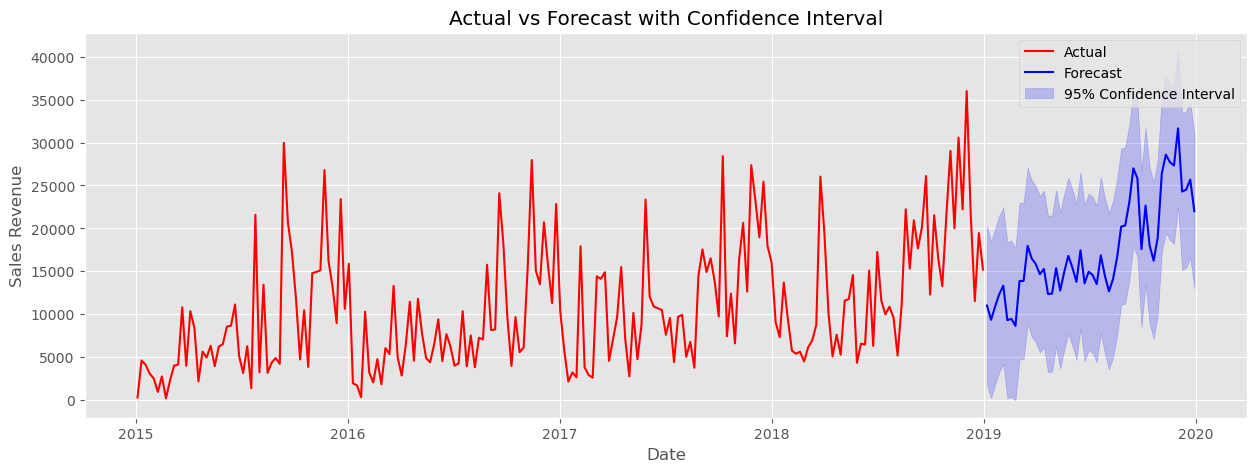

In [64]:
# Forecast for the next 52 weeks (1 year)
forecast = sarima_model.get_forecast(steps=52)

# Generate forecast DataFrame
forecast_df = forecast.summary_frame().rename(columns={'mean': 'Forecast'})

# Create forecast index
forecast_index = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W')

# Update the index of forecast_df
forecast_df.index = forecast_index

# Ensure lower confidence interval does not drop below 0
forecast_df['mean_ci_lower'] = forecast_df['mean_ci_lower'].clip(lower=0)

# Plot actual vs forecast
plt.figure(figsize=(15, 5))
plt.plot(weekly_sales['Sales_Revenue'], label='Actual', color='red')
plt.plot(forecast_df['Forecast'], label='Forecast', color='blue')

# Plot confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('Actual vs Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.show()

In [65]:
sum_s_forecast = forecast_df['Forecast'].sum()

print(f"Next year's forecasted Total Sales Revenue: ${round(sum_s_forecast, 2)}")
print(f"Most Recent Year's Annual Sales Revenue: ${current_annual_sales_revenue}")

percentage_increase = ((sum_s_forecast - current_annual_sales_revenue) / current_annual_sales_revenue) * 100
print(f"Projected Annual Increase in Sales Revenue for Next Year: {round(percentage_increase, 2)}%")

Next year's forecasted Total Sales Revenue: $903182.81
Most Recent Year's Annual Sales Revenue: $722051.82
Projected Annual Increase in Sales Revenue for Next Year: 25.09%


In [66]:
# Export our model

# Define the file path
folder_path = '../models'
model_path = os.path.join(folder_path, 'sarima_model.pkl')

# Export the model
joblib.dump(sarima_model, model_path)

['../models/sarima_model.pkl']

# Summary

## After training 3 different models and forecasting the next 12 months of sales revenue, these are our results:

## The Prophet Model predicts a 25.8% increase in sales revenue next year
## The Holt-Winters Exponential Smoothing Model predicts a 39.43% increase in sales revenue next year
## The SARIMA Model predicts a 25.09% increase in sales revenue next year

## It is very encouraging that 2 of the models were within 1% of each other in their predictions. For our use case in using these predictions to make the determination of whether or not to proceed with such a large capital expenditure in expanding the company's territory, we would want to take a very conservative approach. To this end, we will use the lowest prediction to decide whether it is prudent to proceed with the expansion or not.

## The SARIMA Model had the lowest prediction; an increase of 25.09% in sales revenue next year. This is well above our required threshold of 15% annual growth, so the data shows we can proceed with the expansion.